In [1]:
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, UpSampling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

batch_size = 32

averaging_kernel_weight_3x3 = 1./9

# as calculated in step1_coordinates_to_dense_layer_weights.py
weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches in their original shape, 56x56
        patches_out -- tensor of the original patches center cropped to 48x48 
                       and then downsampled to 24x24
    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]  # center-crop to 48x48 (original BRIEF input patch size)
        patch_out = block_reduce(patch_out, (2, 2), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    patches_in = np.expand_dims(patches_in, -1)
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    patches_out = np.expand_dims(patches_out, -1)
        
    print("in", patches_in.shape, "; out", patches_out.shape)
    
    return patches_in, patches_out

In [6]:
x_train, y_train = loading_data(train_data_dir)
x_validation, y_validation = loading_data(validation_data_dir)

in (64598, 56, 56, 1) ; out (64598, 24, 24, 1)
in (8075, 56, 56, 1) ; out (8075, 24, 24, 1)


In [7]:
input_shape = (input_patch_size, input_patch_size, 1)

# encoder
input_img = Input(shape=input_shape)
x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)

# decoder
x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)

decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [8]:
# set the initial weights of the decoder to the weights learned in step 2

model_version_previous = '0.1.0.0.0_decoder_datagen_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24'
brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')
print(brief_ae_previous.get_layer(index=7).get_weights()[0].shape)
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

(512, 1152)


In [9]:
image_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.2,
    width_shift_range=0.3, height_shift_range=0.3, shear_range=0.2,
    horizontal_flip=False, fill_mode="nearest")

In [11]:
model_version = '0.1.0.0.4_whole_datagen_dense1152_conv32_conv32_up_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output24X24_increasedgeometricnoise_train50more'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# history_callback = brief_ae.fit_generator(image_datagen.flow(x_train, y_train, batch_size),
#                 steps_per_epoch=x_train.shape[0],
#                 epochs=50,
#                 validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
#                 validation_steps=x_validation.shape[0],
#                 callbacks=[checkpointer]
#                 )

# brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

original patch:


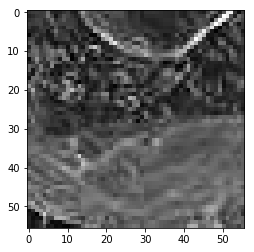

original patch center-cropped and downsampled:


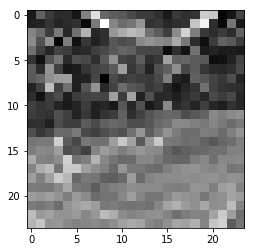

reconstructed patch from its BRIEF encoding:


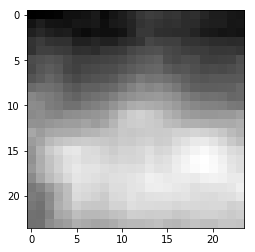

RMSE: 26.934983879327774

original patch:


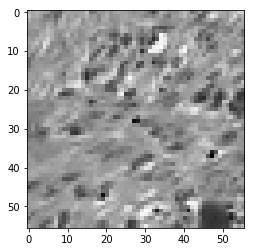

original patch center-cropped and downsampled:


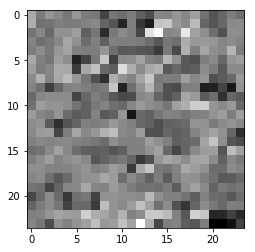

reconstructed patch from its BRIEF encoding:


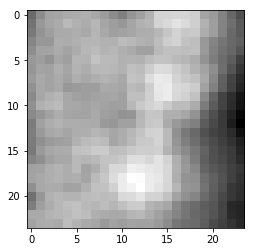

RMSE: 23.635406233370304

original patch:


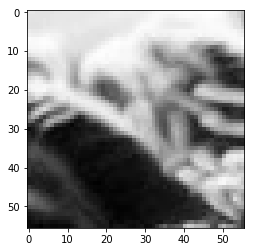

original patch center-cropped and downsampled:


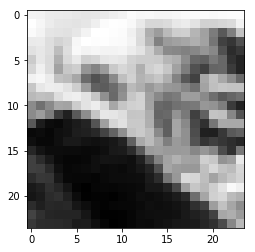

reconstructed patch from its BRIEF encoding:


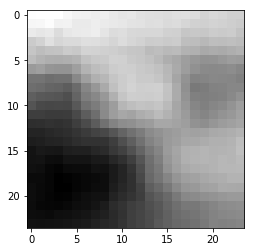

RMSE: 49.4804584980011

original patch:


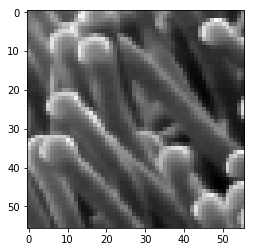

original patch center-cropped and downsampled:


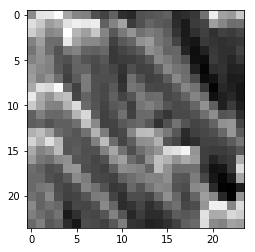

reconstructed patch from its BRIEF encoding:


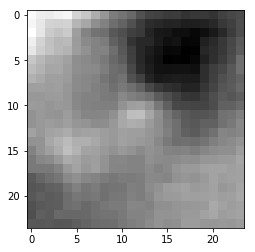

RMSE: 22.35830046236515

original patch:


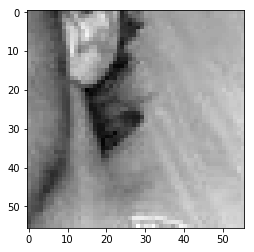

original patch center-cropped and downsampled:


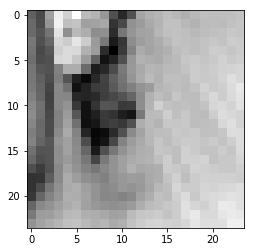

reconstructed patch from its BRIEF encoding:


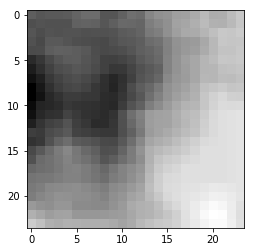

RMSE: 10.74581578373909

original patch:


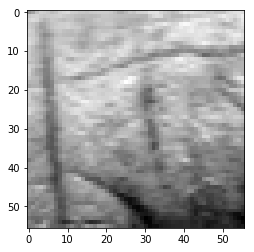

original patch center-cropped and downsampled:


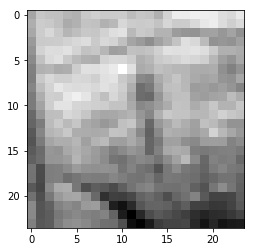

reconstructed patch from its BRIEF encoding:


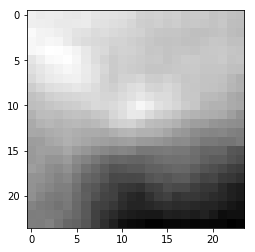

RMSE: 11.783579047769308

original patch:


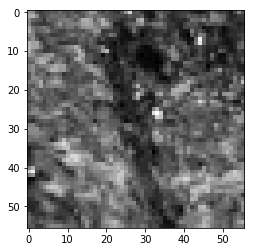

original patch center-cropped and downsampled:


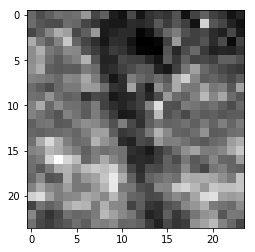

reconstructed patch from its BRIEF encoding:


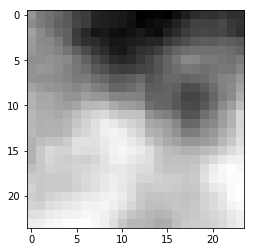

RMSE: 32.11529530584812

original patch:


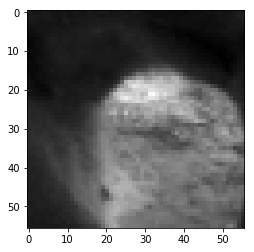

original patch center-cropped and downsampled:


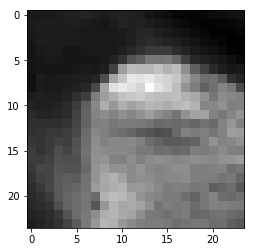

reconstructed patch from its BRIEF encoding:


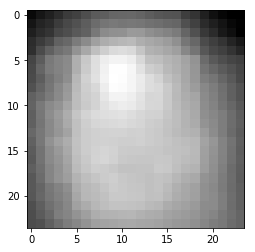

RMSE: 36.39207221567631

original patch:


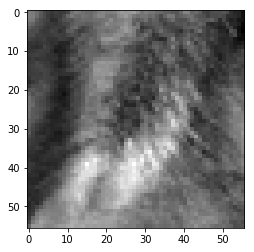

original patch center-cropped and downsampled:


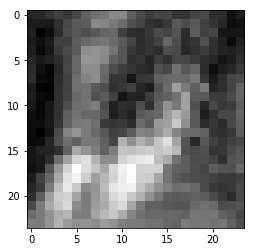

reconstructed patch from its BRIEF encoding:


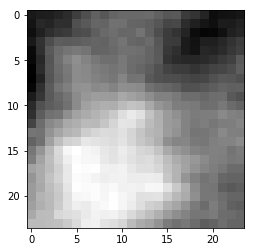

RMSE: 13.34457328543067

original patch:


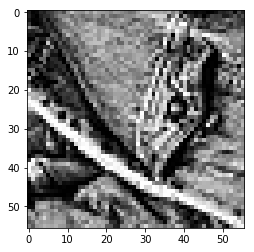

original patch center-cropped and downsampled:


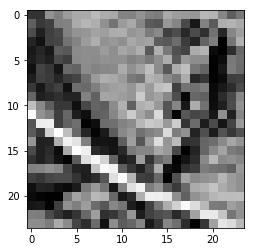

reconstructed patch from its BRIEF encoding:


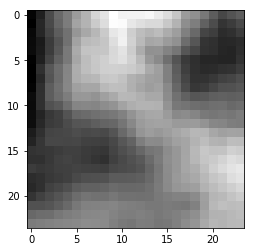

RMSE: 57.82363660633564

average RMSE 0.11161338090896607


In [12]:
# show some reconstructed patches

images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()
files = files[: 10]

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    print("original patch:")
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    print("original patch center-cropped and downsampled:")
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (2, 2), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    print("reconstructed patch from its BRIEF encoding:")
    pred_1 = predictions[i].reshape((24, 24))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print("RMSE:", rmse * 255)
    rmses += rmse
    
    print("\n==============================================")
    
rmses /= len(images)
print("average RMSE", rmses)